# Varijacioni kvantni rešavač sopstvenih vrednosti (VQE)

VQE je jedan od najpoznatijih algoritama kvantnog računarstva. Glavna primena mu je nalaženje najmanje sopstvene vrednosti ermitske matrice $H$, ali se može modifikovati da nalazi i najveću sopstvenu vrednost. Algoritam kombinuje klasično i kvantno računarstvo, koristeći prednosti obe tehnologije.

Osnovni elementi algoritma su:
* ansatz - predstavlja parametrizovani jedinični vektor $\ket{\psi(\theta)}$; dat je kao kvantno kolo $U(\theta)$ koje generiše taj vektor;
* parametri - služe da inicijalizuju ansatz;
* optimizacioni algoritam - može da se koristi gradijentni spust, Nelder-Mead, COBYLA ili neki drugi

Cilj algoritma je da pronađe $\min_{\theta} \bra{\psi(\theta)} H \ket{\psi(\theta)}$. Ovaj minimum je gornje ograničenje na najmanju sopstvenu vrednost matrice $H$. Može se pokazati da je $\min_{v, |v = 1|} \bra{v} H \ket{v}$ najmanja sopstvena vrednost od $H$. Naime, neka su sopstveni vektori matrice $H$ $\lambda_1, \ldots, \lambda_n$ i neka odgovarajući sopstveni vektori $\ket{e_1}, \ldots, \ket{e_n}$ čine ortonormiranu bazu prostora $\mathbb{C}^{2^{\otimes n}}$. Tada se vektor $\ket{v}$ može rastaviti na bazu $\ket{e_1}, \ldots, \ket{e_n}$:
\begin{align*}
    \ket{v} = c_1 \ket{e_1} + \ldots + c_n \ket{e_n},
\end{align*} za koeficijente $c_1, \ldots, c_n \in \mathbb{C}$.

Odavde je $\bra{v} = \bar{c_1} \bra{e_1} + \ldots + \bar{c_n} \bra{e_n}$, pa dobijamo:
\begin{align*}
    \bra{v} H \ket{v} = \bra{v} (c_1 \lambda_1 \ket{e_1} + \ldots + c_n \lambda_n \ket{e_n}) = c_1^2 \lambda_1 + \ldots + c_n^2 \lambda_n.
\end{align*}

Poslednja jednakost sledi na osnovu činjenice da $\ket{e_i}$ čine ortonormiranu bazu, pa je $\bra{e_i}\ket{e_j} = \delta_{ij}$. Neka su sopstvene vrednosti uređene na sledeći naćin $\lambda_1 \leq \ldots \leq \lambda_n$. Minimizacija se sada svodi na nalaženje parametara $c_i$ tako da je poslednja suma najmanja. Imajući u vidu uređenje sopstvenih vrednosti, nalazimo da se minimum postiže za $c_i = \delta_{1i}$ i da je taj minimum jednak $\lambda_1$.

Na sličan način smo mogli da nađemo najveću sopstvenu vrednost. Ako tražimo $\max_{v, |v| = 1} \bra{v} H \ket{v}$, onda se taj maksimum postiže za $c_{i} = \delta_{ni}$ i on iznosi $\lambda_n$. U tom slučaju, ansatz obezbeđuje nalaženje donjeg ograničenja za najveću sopstvenu vrednost.

Sada možemo opisati kako radi algoritam. Glavni koraci su:
1. nađi početne parametre
2. izvršavaj u petlji:
   1. pokreni $U(\theta)\ket{0}$ da dobiješ ansatz $\ket{\psi(\theta)}$
   2. pronađi vrednost $m = \bra{\psi(\theta)} H \ket{\psi(\theta)}$
   3. ubaci $m$ u optimizacioni algoritam da dobiješ nove parametre $\theta$
   4. ako je ispunjen uslov izlaska iz optimizacije, izađi iz petlje
3. poslednju vrenost $m$ izbaci kao rezultat.

Nalaženje vrednosti $m$ se izvodi većinski na kvantnom računaru. Najpre se matrica $H$ dopuni do matrice dimenzija $2^n \times 2^n$. Onda se ona rastavi na bazu Paulijevih stringova, odnosno operatora oblika $P_i = \sigma_1 \otimes \ldots \otimes \sigma_n$, gde je $\sigma_j \in \{I, X, Y, Z\}$. Računanje se sada može svesti na računanje sume vrednosti $m_i = \bra{\psi(\theta)} P_i \ket{\psi(\theta)}$. Matrica $P_i$ se može dijagonalizovati primenom odgovarajućeg kvantnog kola $M$ takvog da je $M^{\dagger} P_i M = D_i$, za neku dijagonalnu matricu $D_i$. Konstrukcija je takva da su nam sopstvene vrednosti $\lambda_j$ od $D_i$ poznate, a sopstveni vektori su kanonska baza prostora $\mathbb{C}^{2^n}$. Dakle, potrebno je sada samo izračunati $\bra{M \psi(\theta)} D_i \ket{M \psi(\theta)}$. Rastavljenjem $\ket{M \psi(\theta)} = \sum_{j = 0}^{2^n - 1} c_j \ket{\text{bin}(j)}$, gde je $c_i \in \mathbb{C}$ i $\text{bin}(j)$ binarna reprezentacija broja $j$, dobijamo $m_i = \sum_{j = 0}^{2^{n} - 1} c_j^2 \lambda_j$. Koeficijenti $c_i^2$ predstavljaju verovatnoću da na kvantno merenje izbaci broj $j$. Oni se mogu dobiti tako što se više puta generiše i meri vektor $M \psi(\theta)$ na kvantnom računaru, dok se ne dobije dovoljno dobra aproksimacija za $c_i^2$. Nakon toga, potrebno je samo te koeficijente na klasičnom računaru pomnožiti sa $\lambda_j$. Množenje sa težinom uz Paulijev operator i sabiranje svih delova da se dobije $m$ se takođe izvodi na klasičnom računaru. **IBM Qiskit** ima klase **Estimator** i **BackendEstimatorV2** koje rade sav ovaj posao za nas.

## Implementacija

Za implementaciju ćemo koristiti gotove alate iz **IBM Qiskit**.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
 
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

Potrebno je sada povezati se na kvantni računar. Pošto nemamo pristup kvantnom računaru, onda ćemo se vezati za lokalni simulator.

In [2]:
service = QiskitRuntimeService(channel = "local")
backend = service.least_busy()
service

Sada možemo učitati neku ermitsku matricu $H$. Nju prevodimo u **SparsePauliOp**, što je zapravo reprezentacija matrice u bazi Paulijevih stringova. Pazimo na dimenzije matrice: matrica mora da ima dimenzije $2^n \times 2^n$. Ovde sam dodao na dijagonali $1$, jer je on negde između sopstvenih vrednosti matrice $H$. Dopunjavanje se može izvršiti tako što izaberemo $k + 2$ nasumičnih jediničnih vektora, gde je $k$ broj kolona i vrsta koje treba dodati da se dopuni matrica. Izračunavanjem funkcionala u njima i izborom srednjih $k$ vrednosti, možemo te vrednosti da ubacimo u matricu. Ne znam koliko je to pametan pristup, deluje mi da se niko nije bavio ovim problemom. Ako se matrica dopuni dijagonalnim poljima prevelike vrednosti, prilikom estimacije može da dođe do toga da te vrednosti igraju znantno veću ulogu u izrazu za $m$, pa na izlazu iz optimizatora izađe prevelika sopstvena vrednost.

In [3]:
H = np.array([[1, 2, 3, 0], [2, 4, 5, 0], [3, 5, 7, 0], [0, 0, 0, 1]])
hamiltonian = SparsePauliOp.from_operator(H)

Postoji više načina da se izabere ansatz, a ovde koristimo **Efficient_SU2**, jer je pogodan za dosta problema.

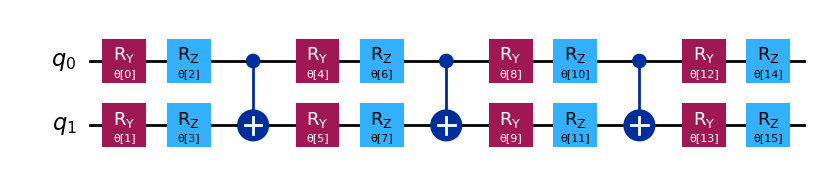

In [4]:
ansatz = efficient_su2(hamiltonian.num_qubits)
ansatz.draw("mpl")

In [5]:
num_params = ansatz.num_parameters
num_params

16

Da bi se efikasno izvršavao ansatz na kvantnom računaru, potrebno je prevesti ga u arhitekturu kvantnog računara i optimizovati. To postižu naredne linije koda. Ovaj korak nije suštinski za rad algoritma.

In [6]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
ansatz_isa = pm.run(ansatz)

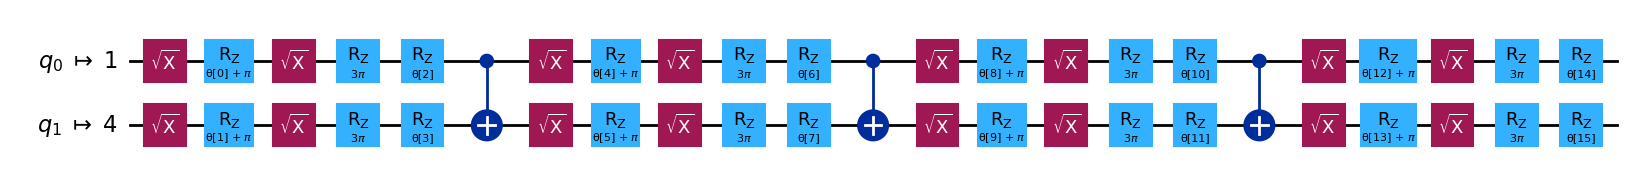

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

Slično se uradi i sa Hamiltonijanom.

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

Koristićemo optimizator COBYLA. Potrebno je definisati funkciju koja određuje trenutni minimum na osnovu zadatih parametara.

In [9]:
def trenutni_minimum(params, ansatz, hamiltonian, estimator):

    # ovaj deo koda generiše argumente za estimator
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    # u dictionary ubacujemo vrednosti dosadašnjih energija
    
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(
        f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]"
    )
 
    return energy

In [10]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

Generišemo nasumično izabrane parametre za ansatz.

In [11]:
x0 = 2 * np.pi * np.random.random(num_params)

Svi delovi su spremni, samo treba pokrenuti na kvantnom računaru. Pokrećemo u modu sesije, jer ima dosta sličnih operacija koje iteriraju.

In [12]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000
 
    res = minimize(
        trenutni_minimum,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        options = {'maxiter' : 200, 'disp' : True}
    )

Iters. done: 1 [Current cost: 1.3807999999999994]
Iters. done: 2 [Current cost: 3.4058499999999996]
Iters. done: 3 [Current cost: 0.12484999999999907]
Iters. done: 4 [Current cost: 0.4015999999999995]
Iters. done: 5 [Current cost: 1.6708]
Iters. done: 6 [Current cost: 0.6253500000000001]
Iters. done: 7 [Current cost: 1.2531]
Iters. done: 8 [Current cost: 0.16329999999999983]
Iters. done: 9 [Current cost: 2.0842]
Iters. done: 10 [Current cost: 0.7587499999999999]
Iters. done: 11 [Current cost: 0.19410000000000044]
Iters. done: 12 [Current cost: 0.2850999999999999]
Iters. done: 13 [Current cost: 0.7307999999999997]
Iters. done: 14 [Current cost: 0.4073499999999999]
Iters. done: 15 [Current cost: 1.9637500000000003]
Iters. done: 16 [Current cost: 0.47725000000000006]
Iters. done: 17 [Current cost: 2.1893]
Iters. done: 18 [Current cost: 1.2942000000000007]
Iters. done: 19 [Current cost: 0.13529999999999975]
Iters. done: 20 [Current cost: 0.1845499999999991]
Iters. done: 21 [Current cost: 0

Ispisujemo rezultat optimizatora.

In [13]:
min(cost_history_dict["cost_history"])

-0.012150000000000272

Možemo i da nacrtamo grafik da prikažemo kako je izgledala pretraga.

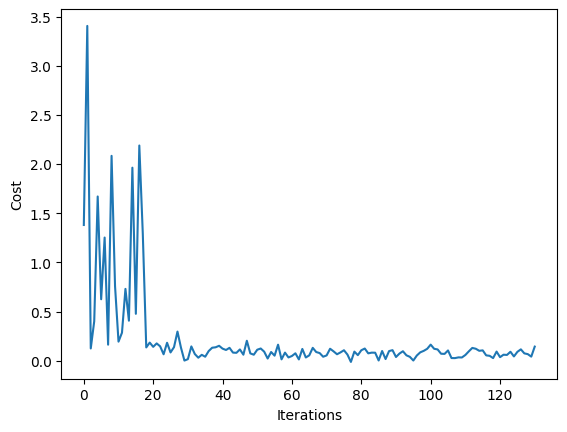

In [14]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

Dobili smo $-0.01$, a prava najmanja sopstvena vrednost je $-0.25$.

Sad ćemo sve ovo da iskoristimo da nađemo najveću sopstvenu vrednost.

In [15]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [16]:
x0 = 2 * np.pi * np.random.random(num_params)

In [17]:
def trenutni_maksimum(params, ansatz, hamiltonian, estimator):
    return -1 * trenutni_minimum(params, ansatz, hamiltonian, estimator)

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000
 
    res = minimize(
        trenutni_maksimum,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        options = {'maxiter' : 200, 'disp' : True}
    )

Iters. done: 1 [Current cost: 1.3254500000000007]
Iters. done: 2 [Current cost: 0.4498500000000003]
Iters. done: 3 [Current cost: 4.2093]
Iters. done: 4 [Current cost: 1.8532000000000004]
Iters. done: 5 [Current cost: 4.304900000000001]
Iters. done: 6 [Current cost: 4.66755]
Iters. done: 7 [Current cost: 4.42445]
Iters. done: 8 [Current cost: 3.5671000000000004]
Iters. done: 9 [Current cost: 1.6207000000000005]
Iters. done: 10 [Current cost: 4.74215]
Iters. done: 11 [Current cost: 5.990450000000001]
Iters. done: 12 [Current cost: 5.4935]
Iters. done: 13 [Current cost: 4.723650000000001]
Iters. done: 14 [Current cost: 2.54275]
Iters. done: 15 [Current cost: 7.24245]
Iters. done: 16 [Current cost: 5.286399999999999]
Iters. done: 17 [Current cost: 7.03365]
Iters. done: 18 [Current cost: 8.7584]
Iters. done: 19 [Current cost: 8.46505]
Iters. done: 20 [Current cost: 9.20795]
Iters. done: 21 [Current cost: 8.9239]
Iters. done: 22 [Current cost: 8.9448]
Iters. done: 23 [Current cost: 7.997500

In [18]:
max(cost_history_dict["cost_history"])

11.1561

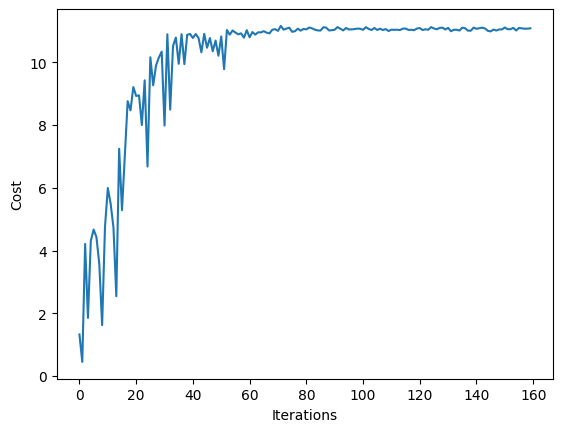

In [19]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

Dobili smo $11.16$, a prava vrednost je $11.91$.